In [1]:
from sklearn.base import BaseEstimator

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MyDummyClassifier(BaseEstimator) :
    def fit(self, X, y=None) :
        pass
    
    def predict(self, X) :
        pred = np.zeros((X.shape[0],1))
        
        for i in range(X.shape[0]) :   # 데이터 건 수 만큼 반복
            if X['Sex'].iloc[i] == 1 : # 자기 위치의 값을 불러와서, 성별이 1(남자) 일 때,
                pred[i] = 0 # 사망
            else :
                pred[i] = 1 # 생존
                
            return pred
        

def fillna(df) :
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    
    return df
    
def drop_features(df) :
    df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
    
    return df


def format_features(df) :
    from sklearn.preprocessing import LabelEncoder
    
    df.Cabin = df.Cabin.str[:1]
    
    # categorical 컬럼이름
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features :
        df[feature] = LabelEncoder().fit_transform(df[feature])
        
    return df


def transform_features(df) :
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
titanic_df = pd.read_csv('titanic_train.csv')

# X, y 분리
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(columns = ['Survived'])

# 전처리
X_titanic_df = transform_features(X_titanic_df)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 모델 만들기
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
pred = myclf.predict(X_test)
accuracy_score(y_test, pred)

0.6145251396648045

---

In [5]:
from sklearn.datasets import load_digits

In [6]:
class MyFakeClassifier(BaseEstimator) :
    def fit(self, X, y) :
        pass
    
    def predict(self, X) :
        return np.zeros(
                            (X.shape[0], 1),
                            dtype=bool
                        )

In [7]:
digits = load_digits()

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

y_test.shape, pd.Series(y_test).value_counts()

((450,),
 0    405
 1     45
 dtype: int64)

In [8]:
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
pred = fakeclf.predict(X_test)
accuracy_score(y_test, pred)

0.9

### => 정확도가 믿을 값이 못된다.

---

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
confusion_matrix(y_test, pred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [12]:
def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print()
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}')
    

In [13]:
titanic_df = pd.read_csv('titanic_train.csv')

# X, y 분리
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(columns = ['Survived'])

# 전처리
X_titanic_df = transform_features(X_titanic_df)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

오차행렬
[[92 18]
 [16 53]]

정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


---

In [19]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
pred_proba[:7], pred[:7]

(array([[0.85143272, 0.14856728],
        [0.89230123, 0.10769877],
        [0.93333601, 0.06666399],
        [0.05347494, 0.94652506],
        [0.3139637 , 0.6860363 ],
        [0.4899739 , 0.5100261 ],
        [0.08208226, 0.91791774]]),
 array([0, 0, 0, 1, 1, 1, 1], dtype=int64))

---
### 임계값 조정

In [23]:
from sklearn.preprocessing import Binarizer

In [24]:
X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

In [27]:
binarizer = Binarizer(threshold=0.0) # threshold 보다 >= 이면 0 
binarizer.fit_transform(X)

array([[1., 0., 1.],
       [1., 0., 0.],
       [0., 1., 1.]])

In [35]:
custom_threshold=0.5
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[92 18]
 [16 53]]

정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681


In [38]:
custom_threshold=0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[86 24]
 [13 56]]

정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116


In [43]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds) :
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
        custom_predict = binarizer.transform(pred_proba_1)
        print('임계값 : ', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
        print('-'*60)
        
        

In [44]:
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 :  0.4
오차행렬
[[86 24]
 [13 56]]

정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116
------------------------------------------------------------
임계값 :  0.45
오차행렬
[[91 19]
 [14 55]]

정확도 : 0.8156, 정밀도 : 0.7432, 재현율 : 0.7971
------------------------------------------------------------
임계값 :  0.5
오차행렬
[[92 18]
 [16 53]]

정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681
------------------------------------------------------------
임계값 :  0.55
오차행렬
[[97 13]
 [18 51]]

정확도 : 0.8268, 정밀도 : 0.7969, 재현율 : 0.7391
------------------------------------------------------------
임계값 :  0.6
오차행렬
[[99 11]
 [25 44]]

정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377
------------------------------------------------------------


---

In [45]:
from sklearn.metrics import precision_recall_curve

In [46]:
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba_class1)

In [49]:
precision.shape, recall.shape, thresholds.shape

((167,), (167,), (166,))

In [50]:
thr_index = np.arange(0, thresholds.shape[0], 15)
thr_index

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165])

In [54]:
print(np.round(precision[thr_index], 3))
print(np.round(recall[thr_index], 3))
print(np.round(thresholds[thr_index], 3))

[0.399 0.418 0.464 0.52  0.594 0.659 0.724 0.803 0.826 1.    1.    1.   ]
[1.    0.957 0.928 0.928 0.913 0.87  0.797 0.71  0.551 0.449 0.232 0.014]
[0.059 0.096 0.115 0.148 0.191 0.281 0.43  0.57  0.65  0.799 0.913 0.969]


In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as kicker

In [62]:
def precision_recall_curve_plot(y_test, pred_proba) :
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    
    # precision
    plt.plot(thresholds, precision[0:threshold_boundary],
             linestyle='--', label='precision')
    
    # recalls
    plt.plot(thresholds, recalls[0:threshold_boundary],
             label='recalls')
    
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #범례
    plt.legend()
    
    # 격자
    plt.grid()
    
    
    plt.show()
    

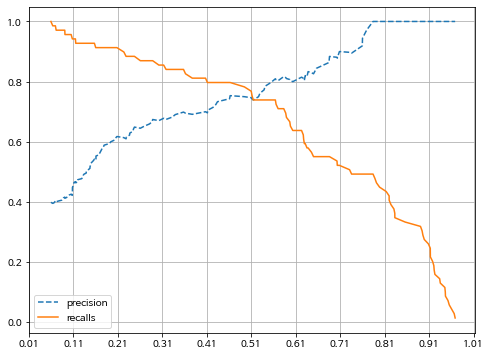

In [63]:
precision_recall_curve_plot(y_test, pred_proba_class1)

---

In [64]:
from sklearn.metrics import f1_score

In [65]:
f1 = f1_score(y_test, pred)
f1

0.7571428571428571

In [67]:
def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    
    print('오차행렬')
    print(confusion)
    print()
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}')
    

In [68]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds) :
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
        custom_predict = binarizer.transform(pred_proba_1)
        print('임계값 : ', custom_threshold)
        
        # 사용자 지정 함수 사용.
        get_clf_eval(y_test, custom_predict)
        
        print('-'*60)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값 :  0.4
오차행렬
[[86 24]
 [13 56]]

정확도 : 0.7933, 정밀도 : 0.7000, 재현율 : 0.8116, F1 : 0.7517
------------------------------------------------------------
임계값 :  0.45
오차행렬
[[91 19]
 [14 55]]

정확도 : 0.8156, 정밀도 : 0.7432, 재현율 : 0.7971, F1 : 0.7692
------------------------------------------------------------
임계값 :  0.5
오차행렬
[[92 18]
 [16 53]]

정확도 : 0.8101, 정밀도 : 0.7465, 재현율 : 0.7681, F1 : 0.7571
------------------------------------------------------------
임계값 :  0.55
오차행렬
[[97 13]
 [18 51]]

정확도 : 0.8268, 정밀도 : 0.7969, 재현율 : 0.7391, F1 : 0.7669
------------------------------------------------------------
임계값 :  0.6
오차행렬
[[99 11]
 [25 44]]

정확도 : 0.7989, 정밀도 : 0.8000, 재현율 : 0.6377, F1 : 0.7097
------------------------------------------------------------


---

In [69]:
from sklearn.metrics import roc_curve

In [72]:
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

In [73]:
thr_index = np.arange(1, thresholds.shape[0],5)
thr_index

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51])

In [74]:
fprs[thr_index]

array([0.        , 0.04545455, 0.09090909, 0.10909091, 0.22727273,
       0.26363636, 0.46363636, 0.51818182, 0.72727273, 0.85454545,
       1.        ])

In [77]:
def roc_curve_plot(y_test, pred_proba) :
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)    
    plt.plot(fprs,tprs,label='Roc')
    plt.show()

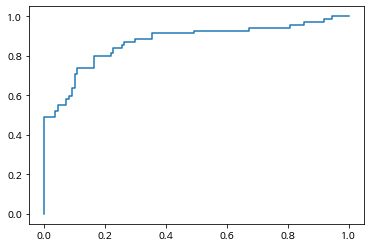

In [78]:
roc_curve_plot(y_test, pred_proba_class1)

---

### 오차행렬